In [2]:
import os

images = [os.path.join('data/validation', fname) for fname in os.listdir('data/validation')]

In [3]:
image_names = [os.path.splitext(os.path.basename(img))[0] for img in images]

In [4]:
import json

with open('data/nocap_val_4500_captions.json', 'r') as f:
    captions_data = json.load(f)

In [5]:
grouped_results = []
for img in captions_data['images']:
    image_name = os.path.splitext(img['file_name'])[0]
    image_id = img['id']
    # Get all captions for this image_id
    image_captions = [
        {'captionid': cap['id'], 'caption': cap['caption']}
        for cap in captions_data['annotations'] if cap['image_id'] == image_id
    ]
    grouped_results.append({
        'image_name': image_name,
        'image_id': image_id,
        'captions': image_captions
    })

In [6]:
grouped_results[:1]

[{'image_name': '0013ea2087020901',
  'image_id': 0,
  'captions': [{'captionid': 0,
    'caption': 'A baby is standing in front of a house.'},
   {'captionid': 1, 'caption': 'A little girl in a white jacket and sandals.'},
   {'captionid': 2, 'caption': 'A young child stands in front of a house.'},
   {'captionid': 3,
    'caption': 'A child is wearing a white shirt and standing on a side walk. '},
   {'captionid': 4,
    'caption': 'A little boy is standing in his diaper with a white shirt on.'},
   {'captionid': 5,
    'caption': 'A child wearing a diaper and shoes stands on the sidewalk.'},
   {'captionid': 6,
    'caption': 'A child is wearing a light-colored shirt during the daytime.'},
   {'captionid': 7,
    'caption': 'A little kid standing on the pavement in a shirt. '},
   {'captionid': 8,
    'caption': 'Black and white photo of a little girl smiling.'},
   {'captionid': 9,
    'caption': 'a cute baby is standing alone with white shirt'}]}]

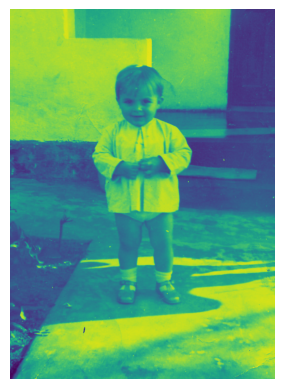

In [7]:
from PIL import Image

import matplotlib.pyplot as plt

img_path = 'data/validation/' + grouped_results[0]['image_name'] + '.jpg'
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
import torch

# import vision transformer

from vit_pytorch.simple_vit_with_patch_dropout import SimpleViT
from vit_pytorch.extractor import Extractor

vit = SimpleViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    patch_dropout = 0.5  # https://arxiv.org/abs/2212.00794
)

vit = Extractor(vit, return_embeddings_only = True, detach = False)

In [9]:
from coca_pytorch.coca_pytorch import CoCa

coca = CoCa(
    dim = 512,                     # model dimension
    img_encoder = vit,             # vision transformer - image encoder, returning image embeddings as (batch, seq, dim)
    image_dim = 1024,              # image embedding dimension, if not the same as model dimensions
    num_tokens = 20000,            # number of text tokens
    unimodal_depth = 6,            # depth of the unimodal transformer
    multimodal_depth = 6,          # depth of the multimodal transformer
    dim_head = 64,                 # dimension per attention head
    heads = 8,                     # number of attention heads
    caption_loss_weight = 1.,      # weight on the autoregressive caption loss
    contrastive_loss_weight = 1.,  # weight on the contrastive loss between image and text CLS embeddings
).cuda()

In [10]:
import json, os, collections

ANN = 'data/nocap_val_4500_captions.json'
IMG_DIR = 'data/validation'  # where you downloaded images

with open(ANN, 'r') as f:
    ann = json.load(f)

# maps
id2file = {img['id']: img['file_name'] for img in ann['images']}
file2id = {v:k for k,v in id2file.items()}

# group refs by image_id
caps_by_id = collections.defaultdict(list)
for a in ann['annotations']:
    caps_by_id[a['image_id']].append(a['caption'])

num_images = len(ann['images'])
lens = [len(caps_by_id[i['id']]) for i in ann['images']]
print(f"#images: {num_images}, min refs: {min(lens)}, max refs: {max(lens)}, mean refs: {sum(lens)/len(lens):.2f}")

# sanity: list any images not having exactly 10 refs
bad = [(i['id'], id2file[i['id']], len(caps_by_id[i['id']])) for i in ann['images'] if len(caps_by_id[i['id']]) != 10]
print("non-10 reference counts:", len(bad))
bad[:5]


#images: 4500, min refs: 10, max refs: 10, mean refs: 10.00
non-10 reference counts: 0


[]

In [11]:
import os
from PIL import Image
from tqdm import tqdm

def load_image(path):
    return Image.open(path).convert("RGB")

def generate_caption(model, pil_img):
    # TODO: YOUR decoding here (greedy/beam). Return a plain string.
    # Example placeholder:
    return "a placeholder caption for this image"

# Produce predictions for ALL images in the JSON file order
preds = []
for img in tqdm(ann['images']):
    image_id = img['id']
    img_path = os.path.join(IMG_DIR, img['file_name'])
    pil_img = load_image(img_path)

    caption = generate_caption(model=None, pil_img=pil_img)  # replace model=None with your CoCa
    preds.append({"image_id": image_id, "caption": caption})

len(preds), preds[:2]


100%|██████████| 4500/4500 [00:15<00:00, 291.70it/s]


(4500,
 [{'image_id': 0, 'caption': 'a placeholder caption for this image'},
  {'image_id': 1, 'caption': 'a placeholder caption for this image'}])

In [12]:
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import json, tempfile

# build a “results” json file from preds
tmp_results = tempfile.NamedTemporaryFile(suffix=".json", delete=False).name
with open(tmp_results, "w") as f:
    json.dump(preds, f)

coco = COCO(ANN)
cocoRes = coco.loadRes(tmp_results)

evaluator = COCOEvalCap(coco, cocoRes)
evaluator.evaluate()

# Print key metrics
for k, v in evaluator.eval.items():
    print(f"{k:8s}: {v:.4f}")


ModuleNotFoundError: No module named 'pycocotools'